In [2]:
#importing the Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

from prophet import Prophet
import pmdarima as pm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [4]:
#Loading the Stock_data "AAPL"
data = yf.download("AAPL",start="2015-01-01", end="2025-01-01")

print(data.head())
data.info()



C:\Users\admin\AppData\Local\Temp\ipykernel_11304\4088544896.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL",start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261044  24.729267  23.821668  24.718171  212818400
2015-01-05  23.577572  24.110148  23.391171  24.030261  257142000
2015-01-06  23.579796  23.839426  23.218087  23.641929  263188400
2015-01-07  23.910437  24.010294  23.677434  23.788387  160423600
2015-01-08  24.829130  24.886826  24.121248  24.238859  237458000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2516 non-null   float64
 1   (High, AAPL)    2516 non-null   float64
 2   (Low, AAPL)     2516 non-null   float64
 3   (Open, AAPL)    2516 non-null   float64
 4   (Volume, AAPL)  2516 non-null   int64  
dtypes: float64(4), int64(1)
memo

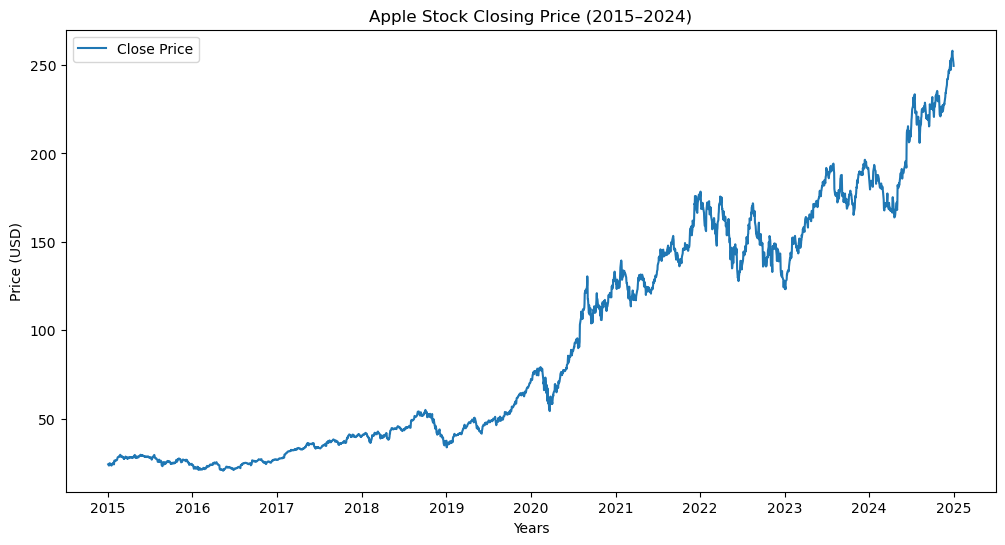

In [5]:
#target column is closing appl
#visualising the close price
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label="Close Price")
plt.title("Apple Stock Closing Price (2015–2024)")
plt.xlabel("Years")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

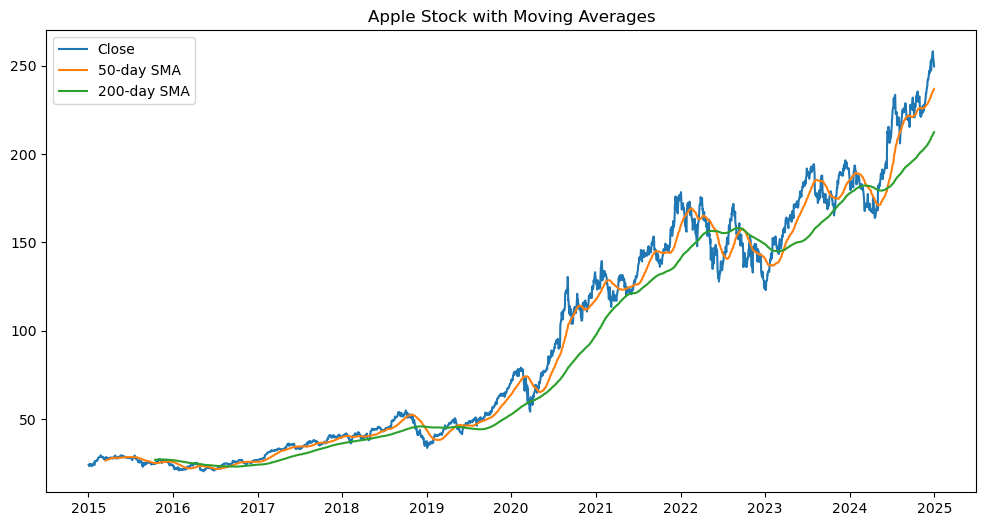

In [6]:
#moving averages to smooth fluctuations in stock prices
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close')
plt.plot(data['SMA_50'], label='50-day SMA')
plt.plot(data['SMA_200'], label='200-day SMA')
plt.title("Apple Stock with Moving Averages")
plt.legend()
plt.show()

In [4]:
#resetting the index because date is used as index 
data = data.reset_index()
#checking the data set after resetting 
print("DataFrame info:")
print(data.info())
print("First few rows:")
print(data.head())

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        2516 non-null   datetime64[ns]
 1   (Close, AAPL)   2516 non-null   float64       
 2   (High, AAPL)    2516 non-null   float64       
 3   (Low, AAPL)     2516 non-null   float64       
 4   (Open, AAPL)    2516 non-null   float64       
 5   (Volume, AAPL)  2516 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB
None
First few rows:
Price        Date      Close       High        Low       Open     Volume
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL
0      2015-01-02  24.261044  24.729267  23.821668  24.718171  212818400
1      2015-01-05  23.577576  24.110152  23.391175  24.030265  257142000
2      2015-01-06  23.579796  23.839426  23.218087  23.641929  263188400
3    

In [5]:
#Train - Test split 80/20

train_size = int(len(data)*0.8)
train,test = data.iloc[:train_size],data.iloc[train_size:]

y_test_actual = test['Close'].values


In [6]:
#setting up ARIMA (baseline model)

arima_model = pm.auto_arima(train['Close'],seasonal=False,stepwise=True,suppress_warnings=True)
arima_pred = arima_model.predict(n_periods = len(test))

arima_mae = mean_absolute_error(y_test_actual,arima_pred)
arima_mape = mean_absolute_percentage_error(y_test_actual,arima_pred)*100
arima_mse = mean_squared_error(y_test_actual,arima_pred)
arima_rmse = np.sqrt(arima_mse)
print(f"\n ARIMA Test \n MAE : {arima_mae:.2f} MAPE:{arima_mape:.2f}%  MSE : {arima_mse:.2f}  RMSE: {arima_rmse:.2f}")


 ARIMA Test 
 MAE : 50.77 MAPE:25.82%  MSE : 3069.34  RMSE: 55.40


In [10]:
#setting up the SARIMA( added seasonality )

sarima_model = pm.auto_arima(train['Close'],seasonal=True,m=5,stepwise=True,suppress_warnings=True)
sarima_pred = sarima_model.predict(n_periods = len(test))

sarima_mae = mean_absolute_error(y_test_actual,sarima_pred)
sarima_mape = mean_absolute_percentage_error(y_test_actual,sarima_pred)*100
sarima_mse = mean_squared_error(y_test_actual,sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
print(f"\n SARIMA Test \n MAE : {sarima_mae:.2f} MAPE:{sarima_mape:.2f}%  MSE : {sarima_mse:.2f}  RMSE: {sarima_rmse:.2f}")



 SARIMA Test 
 MAE : 46.43 MAPE:23.52%  MSE : 2624.66  RMSE: 51.23


In [23]:
#setting up Prophet model
# Prophet needs only 2 columns: 'ds' (datetime) and 'y' (numeric)
#since close is multiIndex we have to change it. prophet needs series not a dataframe

if isinstance(data.columns, pd.MultiIndex):
    close_col = data['Close'].iloc[:, 0]   # first subcolumn under 'Close'
else:
    close_col = data['Close']

prophet_df = pd.DataFrame({
    'ds': pd.to_datetime(data['Date']),
    'y': pd.to_numeric(close_col, errors='coerce')
})
# Train-test split
prophet_train = prophet_df.iloc[:train_size].copy()
prophet_test = prophet_df.iloc[train_size:].copy()

# --- Train Prophet Model ---
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_train)

# --- Forecast into the test period ---
future_test = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='B')
forecast_test = prophet_model.predict(future_test)

# Extract predictions aligned with test period
prophet_pred = forecast_test['yhat'][-len(prophet_test):].values

# --- Evaluate Model ---
y_test_actual = prophet_test['y'].values
prophet_mae = mean_absolute_error(y_test_actual, prophet_pred)
prophet_mape = mean_absolute_percentage_error(y_test_actual, prophet_pred) * 100
prophet_mse = mean_squared_error(y_test_actual, prophet_pred)
prophet_rmse = np.sqrt(prophet_mse)

print(f"\n Prophet Test \nMAE: {prophet_mae:.2f}, MAPE: {prophet_mape:.2f}%  MSE: {prophet_mse:.2f}  RMSE:  {prophet_rmse:.2f}")

02:10:12 - cmdstanpy - INFO - Chain [1] start processing
02:10:13 - cmdstanpy - INFO - Chain [1] done processing



 Prophet Test 
MAE: 29.28, MAPE: 14.49%  MSE: 1315.85  RMSE:  36.27


In [29]:
#setting up LSTM
# Define the time_step (lookback window)
time_step = 60  # Using 60 days as lookback window

# Prepare the data for LSTM
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step)]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split into train and test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
X_train, y_train = create_dataset(train_data, train_data, time_step)
X_test, y_test = create_dataset(test_data, test_data, time_step)

# Reshape for LSTM input (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, 
                        validation_split=0.1, verbose=1)

# Make predictions
lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_mae = mean_absolute_error(y_test_rescaled, lstm_pred_rescaled)
lstm_mse = mean_squared_error(y_test_rescaled, lstm_pred_rescaled)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_rescaled, lstm_pred_rescaled) * 100

print(f"\nUnivariate LSTM Test Results:")
print(f"MAE: {lstm_mae:.4f}")
print(f"MSE: {lstm_mse:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAPE: {lstm_mape:.2f}%")

X_train shape: (1952, 60, 1)
y_train shape: (1952, 1)
X_test shape: (444, 60, 1)
y_test shape: (444, 1)
Epoch 1/20


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0056 - val_loss: 9.5092e-04
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.7115e-04 - val_loss: 0.0012
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.3470e-04 - val_loss: 8.6951e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.9824e-04 - val_loss: 8.6328e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.4009e-04 - val_loss: 7.8630e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.2714e-04 - val_loss: 8.2108e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.0645e-04 - val_loss: 7.5450e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.6954e-04 - val_loss: 0.0011
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.4609e-04 - val_loss: 8.1081e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.3642e-04 - val_loss: 9.9416e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.8834e-04 - val_loss: 7.0954e-0

In [30]:
# ==============================
# Multivariate LSTM Model
# ==============================

# Define the time_step (lookback window) - same as univariate
time_step = 60

# Select features for multivariate model
# Using multiple features: Close, Open, High, Low, Volume
features = ['Close', 'Open', 'High', 'Low', 'Volume']

# Prepare the multivariate data
multivariate_data = data[features].copy()

# Scale each feature separately
scalers = {}
scaled_features = []

for feature in features:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_feature = scaler.fit_transform(multivariate_data[feature].values.reshape(-1, 1))
    scaled_features.append(scaled_feature)
    scalers[feature] = scaler

# Combine scaled features
scaled_multivariate_data = np.hstack(scaled_features)

# Split into train and test
train_size = int(len(scaled_multivariate_data) * 0.8)
train_data_multi = scaled_multivariate_data[:train_size]
test_data_multi = scaled_multivariate_data[train_size:]

# Create sequences for multivariate LSTM
def create_multivariate_dataset(X, time_step=1):
    Xs = []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step), :]  # Take all features
        Xs.append(v)
    return np.array(Xs)

# Create training and testing sequences
X_train_multi = create_multivariate_dataset(train_data_multi, time_step)
X_test_multi = create_multivariate_dataset(test_data_multi, time_step)

# Target is still the 'Close' price (first feature)
y_train_multi = train_data_multi[time_step:, 0]  # Close price is at index 0
y_test_multi = test_data_multi[time_step:, 0]

print(f"X_train_multi shape: {X_train_multi.shape}")
print(f"y_train_multi shape: {y_train_multi.shape}")
print(f"X_test_multi shape: {X_test_multi.shape}")
print(f"y_test_multi shape: {y_test_multi.shape}")

# Build the multivariate LSTM model
multi_lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, len(features))),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

multi_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the multivariate model
multi_history = multi_lstm_model.fit(
    X_train_multi, y_train_multi, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1,
    shuffle=False
)

# Make predictions
multi_pred = multi_lstm_model.predict(X_test_multi)

# Rescale the predictions using the Close price scaler
multi_pred_rescaled = scalers['Close'].inverse_transform(multi_pred)
y_test_multi_rescaled = scalers['Close'].inverse_transform(y_test_multi.reshape(-1, 1))

# Calculate metrics
multi_mae = mean_absolute_error(y_test_multi_rescaled, multi_pred_rescaled)
multi_mse = mean_squared_error(y_test_multi_rescaled, multi_pred_rescaled)
multi_rmse = np.sqrt(multi_mse)
multi_mape = mean_absolute_percentage_error(y_test_multi_rescaled, multi_pred_rescaled) * 100

print(f"\nMultivariate LSTM Test Results:")
print(f"MAE: {multi_mae:.4f}")
print(f"MSE: {multi_mse:.4f}")
print(f"RMSE: {multi_rmse:.4f}")
print(f"MAPE: {multi_mape:.2f}%")

X_train_multi shape: (1952, 60, 5)
y_train_multi shape: (1952,)
X_test_multi shape: (444, 60, 5)
y_test_multi shape: (444,)
Epoch 1/30


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0023 - val_mae: 0.0412
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0025 - mae: 0.0372 - val_loss: 0.0015 - val_mae: 0.0312
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0047 - mae: 0.0454 - val_loss: 0.0048 - val_mae: 0.0602
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0055 - mae: 0.0484 - val_loss: 0.0017 - val_mae: 0.0346
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0082 - mae: 0.0595 - val_loss: 0.0114 - val_mae: 0.0989
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0115 - mae: 0.0720 - val_loss: 0.0264 - val_mae: 0.1564
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0137 - mae: 0.0738 - val_loss: 0.0018 - val_mae: 0.0330
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0081 - mae: 0.0627 - val_loss: 0.0016 - val_mae: 0.0326
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0040 - mae: 0.

In [34]:
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM (Univariate)', 'LSTM (Multivariate - Price Only)'],
    'MAE': [arima_mae, prophet_mae, lstm_mae, multi_mae],
    'MAPE': [arima_mape, prophet_mape, lstm_mape, multi_mape],
    'RMSE': [arima_rmse, prophet_rmse, lstm_rmse, multi_rmse]
})

print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
                              Model        MAE       MAPE       RMSE
0                             ARIMA  50.767992  25.824747  55.401633
1                           Prophet  29.283033  14.485761  36.274686
2                 LSTM (Univariate)   4.290082   2.185195   5.429949
3  LSTM (Multivariate - Price Only)  10.819635   5.340848  12.552523


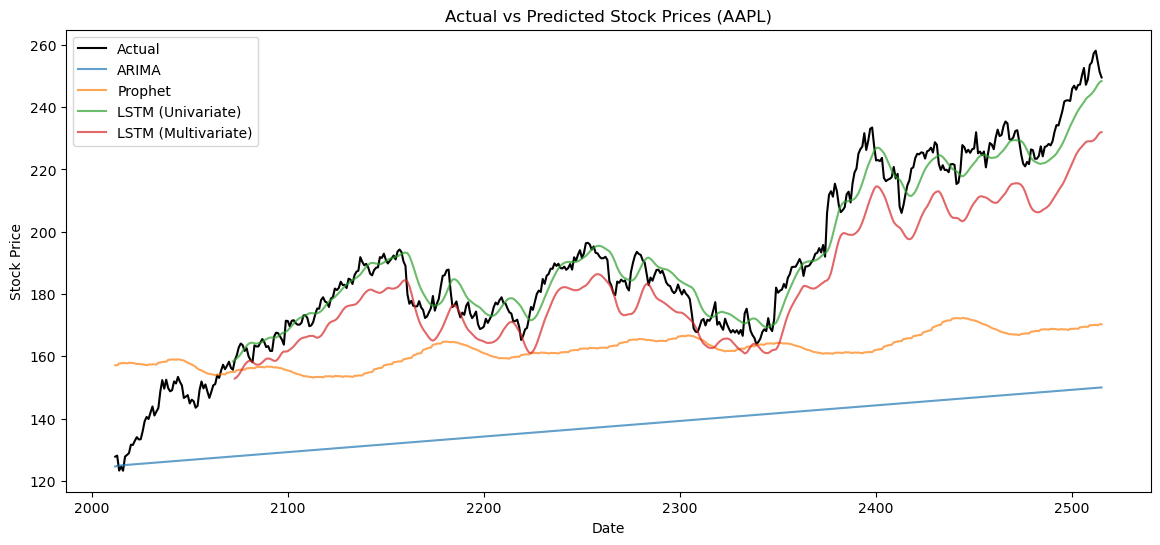

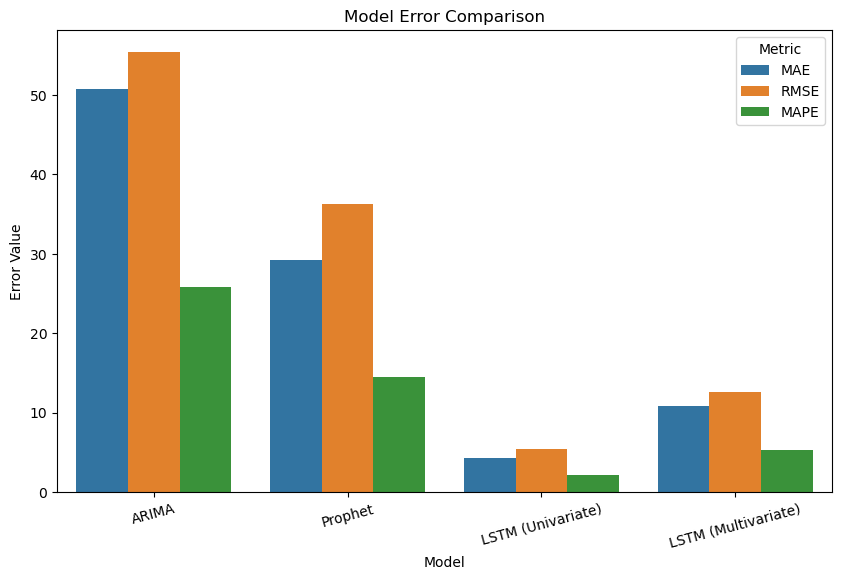

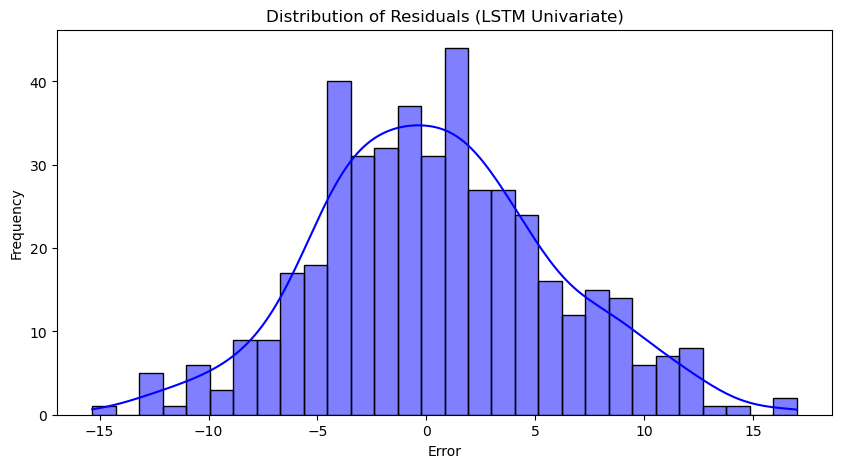

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 1. Actual vs Predicted Plots
# =============================

plt.figure(figsize=(14,6))
plt.plot(test.index, y_test_actual, label="Actual", color="black")

# ARIMA
plt.plot(test.index, arima_pred, label="ARIMA", alpha=0.7)

# Prophet
plt.plot(test.index, prophet_pred, label="Prophet", alpha=0.7)

# LSTM Univariate
plt.plot(test.index[-len(lstm_pred_rescaled):], lstm_pred_rescaled, label="LSTM (Univariate)", alpha=0.7)

# LSTM Multivariate
plt.plot(test.index[-len(multi_pred_rescaled):], multi_pred_rescaled, label="LSTM (Multivariate)", alpha=0.7)

plt.title("Actual vs Predicted Stock Prices (AAPL)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


# =============================
# 2. Error Comparison (Bar Plot)
# =============================

results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM (Univariate)", "LSTM (Multivariate)"],
    "MAE": [arima_mae, prophet_mae, lstm_mae, multi_mae],
    "RMSE": [arima_rmse, prophet_rmse, lstm_rmse, multi_rmse],
    "MAPE": [arima_mape, prophet_mape, lstm_mape, multi_mape]
})

# Melt for seaborn
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Error")

plt.figure(figsize=(10,6))
sns.barplot(data=results_melted, x="Model", y="Error", hue="Metric")
plt.title("Model Error Comparison")
plt.ylabel("Error Value")
plt.xticks(rotation=15)
plt.legend(title="Metric")
plt.show()


# =============================
# 3. Distribution of Errors
# =============================

# Example with LSTM residuals (actual - predicted)
lstm_residuals = y_test_rescaled.flatten() - lstm_pred_rescaled.flatten()

plt.figure(figsize=(10,5))
sns.histplot(lstm_residuals, kde=True, bins=30, color="blue")
plt.title("Distribution of Residuals (LSTM Univariate)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()
